In [1]:
import sys
import os

#Get present working directory
if sys.platform == 'win32' or sys.platform == 'cygwin':
    pwd = !CD
else:
    pwd = !pwd

#Get directory up one level
pwd = pwd[0]
updir = pwd[:pwd.rfind(os.sep)]
#Add same directory as main.py to path
sys.path.insert(0, updir)

#Pretend that we're in main.py now
from algorithms import AbstractSynthesizer, EfrosLeungSynthesizer

[160 184  72]
124 185


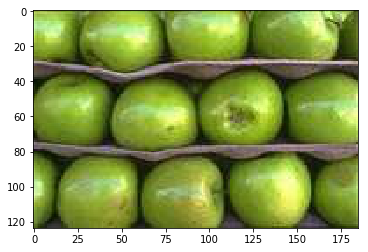

In [3]:
import matplotlib.image as mpimage
import matplotlib.pyplot as plt

#Validate that Pillow is reading the JPEG data correctly
#This may need to be run twice for the cell to behave correctly
imageData = mpimage.imread("../sample-inputs/CMPSC458/apples.jpg")
#imageData = mpimage.imread("../sample-inputs/tri.png")
plt.imshow(imageData)
print(imageData[0][0])
print(len(imageData), len(imageData[0]))

# Test Cells
The following cells are used to test synthesis methods - transparent is 0, range is 0-1

In [4]:
outputSize = (256, 256)

In [23]:
from algorithms.AbstractSynthesizer import AbstractSynthesizer
from algorithms.Pixel import Pixel
import numpy as np
import typing
from typing import List, Union, Tuple
import random
from joblib import Parallel, delayed

class EfrosLeungSynthesizer(AbstractSynthesizer):
    """
    This class realizes a synthesizer based on that of the 1999 paper by Efros & Leung
    See definitions in Abstract Synthesizer for how to use
    """
    
    def __init__(self, textonNeighborhoodDiameter: int):
        if not bool(textonNeighborhoodDiameter%2):
            raise ValueError("textonNeighborhoodDiameter must be an odd integer")
        self.textonNeighborhoodDiameter = textonNeighborhoodDiameter
        self.errorTolerance = 0.2
    
    def getDescription(self) -> str:
        return "Pixel based texture synthesis using methods derived from Efros & Leung's 1999 paper.  Uses fully transparent pixels to identify areas for texture synthesis"
    
    @staticmethod
    def __generateBaseImage(inputData: Union[List, np.ndarray], outputSize: Tuple[int, int]) -> List[List[Pixel]]:
        """
        Generate the image on which to draw; this implementation does not use constrained synthesis.  Use the EfrosLeungConstrainedSynthesizer instead for that.
        Args:
            inputData: An array-like-object of two dimensions with a single value for greyscale or a tuple for RGB/RGBA data
            outputSize: A tuple dictating the size of the output image in (X, Y)
            
        Returns:
            A 2D list of pixel objects
        """
        #Sanity check before generating and seeding
        if outputSize[0] < 3 or outputSize[1] < 3:
            raise ValueError("Output image must be 3x3 or larger")
           
        numchannels = len(inputData[0][0])\
        
        #Generate a blank image of the desired size
        pixels = []
        for i in range(outputSize[1]):
            pixels.append([])
            for j in range(outputSize[0]):
                pixels[i].append(Pixel())
        
        #Populate the seed
        x_samp = random.randint(0,len(inputData[0])-2)
        y_samp = random.randint(0, len(inputData)-2)
        x_out = int(outputSize[1]/2)-1
        y_out = int(outputSize[0]/2)-1
        for i in range(3):
            for j in range(3):
                pixelData = inputData[y_samp+i][x_samp+j]
                if numchannels == 4:
                    pixel = Pixel(pixelData[3], pixelData[0], pixelData[1], pixelData[2], True)
                elif numchannels == 1:
                    pixel = Pixel(pixelData[3], filled=True)
                else:
                    pixel = Pixel(1.0, pixelData[0], pixelData[1], pixelData[2], True)
                pixels[y_out+i][x_out+j] = pixel
                
        return pixels
    
    @staticmethod    
    def __pixelArrayToImage(pixels: List[List[Pixel]], numchannels: int) -> List[List[Pixel]]:
        """
        Converts the pixel array to a matplotlib compatible list
        
        Args:
            pixels: A 2D list of pixels to convert to an image
            numchannels: An integer describing the number of channels
        
        Returns:
            A matplotlib compatible 2D list
        """
        imageData = []
        for row in pixels:
            rowData = []
            for pixel in row:
                if numchannels == 4:
                    rowData.append(pixel.getRGBA())
                elif numchannels == 1:
                    rowData.append(pixel.getGreyscale())
                else:
                    rowData.append(pixel.getRGB())
            imageData.append(rowData)
            
        if numchannels > 1:
            imageData = [[[np.uint8(value) for value in pixel] for pixel in row] for row in imageData]
        else:
            imageData = [[np.uint8(pixel) for pixel in row] for row in imageData]
        
        return imageData
    
    def __gauss2D(self) -> np.ndarray:
        """
        2D gaussian mask with the size of textonNeighborhoodDiameter X textonNeighborhoodDiameter
        
        Returns:
            np.ndarray: textonNeighborhoodDiameterxte X tonNeighborhoodDiameter gaussian filter
        """
        #TODO: make sigma=textonNeighborHoodDiameter/6.4
        size = self.textonNeighborhoodDiameter
        x,y = np.mgrid[-size:size+1,-size:size+1]
        g = np.exp(-(x**2/size+y**2/size))
        out = g/g.sum()
        return out
    
    def __getUnfilledNeighbors(self, pixels: List[List[Pixel]]) -> List[Tuple[int, int]]:
        """
        Get a list of unfilled pixel coordinates from the current image determined by Pixel.isFilled()
        
        Args:
            pixels: The image being generated
        
        Returns:
            unfilledPixels: A list of tuples in (i,j) format
        """
        unfilledPixels = set()
        imax = len(pixels)
        jmax = len(pixels[0])
        for i in range(imax):
            for j in range(jmax):
                if(pixels[i][j].isFilled()):
                    #conservative approach; just use adjacent, no diagonals
                    if i-1 >= 0 and not pixels[i-1][j].isFilled():
                        unfilledPixels.add((i-1,j))
                    if i+1 < imax and not pixels[i+1][j].isFilled():
                        unfilledPixels.add((i+1,j))
                    if j-1 >= 0 and not pixels[i][j-1].isFilled():
                        unfilledPixels.add((i,j-1))
                    if j+1 < jmax and not pixels[i][j+1].isFilled():
                        unfilledPixels.add((i,j+1))
                #if not filled, don't worry
        return unfilledPixels
    
    def __getNeightborhoodWindow(self, pixel: Tuple[int, int], pixels: List[List[Pixel]]) -> List[List[Pixel]]:
        """
        Get the texton surrounding a given pixel
        
        Args:
            pixel: A pixel coordinate in (i,j) format
            pixels: The image being generated
            
        Returns:
            List[List[Pixel]]: The pixels in this texton in 2D format with None as no pixel
        """
        size = self.textonNeighborhoodDiameter
        imax = len(pixels)
        jmax = len(pixels[0])
        output = []
        for i in range(int(pixel[0]-size/2)+1, int(pixel[0]+size/2)+1):
            if i < 0 or i >= imax:
                output.append([None]*jmax)
                continue
            row = []
            for j in range(int(pixel[1]-size/2)+1, int(pixel[1]+size/2)+1):
                if j < 0 or j >= jmax or not pixels[i][j].isFilled():
                    row.append(None)
                    continue
                row.append(pixels[i][j])
            output.append(row)
        return output
    
    def __generateSSDs(self, i: int, reference: Union[List, np.ndarray], template: List[List[Pixel]], ssd: List[List[float]], numChannels: int, gaussMask, validMask, totalWeight):
        """
        Generate SSDs for one i value in an i, j pair; this is provided for parallelism reasons
        
        Args:
            i: The i coordinate for this SSD metric
            reference: The reference image
            template: The texton template
            ssd: The sum of square differences matrix
            numChannels: The number of channels in the image
        """
        for j in range(len(reference[0])):
            for ii in range(len(template)):
                for jj in range(len(template[0])):
                    if template[ii][jj] is None:
                        continue
                    if i-ii < 0 or j-jj < 0:
                        continue
                    if numChannels == 1:
                        distance = (template[ii][jj].getGreyscale()-reference[i-ii][j-jj])**2
                    elif numChannels == 3:
                        RGB = template[ii][jj].getRGB()
                        distance = (RGB[0]-reference[i-ii][j-jj][0])**2
                        distance += (RGB[1]-reference[i-ii][j-jj][1])**2
                        distance += (RGB[2]-reference[i-ii][j-jj][2])**2
                    elif numChannels == 4:
                        RGBA = template[ii][jj].getRGBA()
                        distance = (RGB[0]-reference[i-ii][j-jj][0])**2
                        distance += (RGB[1]-reference[i-ii][j-jj][1])**2
                        distance += (RGB[2]-reference[i-ii][j-jj][2])**2
                        distance += (RGB[3]-reference[i-ii][j-jj][3])**2
                    else:
                        raise ValueError("Unexpected number of channels")
                    ssd[i][j] += distance * validMask[ii][jj] * gaussMask[ii][jj]
            ssd[i][j] /= totalWeight
    
    def __findMatches(self, template: List[List[Pixel]], reference: Union[List, np.ndarray], numChannels: int) -> List[Pixel]:
        """
        Find matches identifies pixels that are a good fit for the target template based on the reference input
        
        Args:
            template: The texton trying to be synthesized
            reference: The reference image from which we are synthesizing
            numChannels: The  number of channels to consider
            
        Returns:
            List[Pixel]: The list of possible pixels
        """
        gaussMask = self.__gauss2D()
        validMask = [[int(entry is not None) for entry in row] for row in template]
        #Total weight calculation
        totalWeight = 0
        for i in range(len(template)):
            for j in range(len(template[0])):
                totalWeight += gaussMask[i][j]*validMask[i][j]
        #SSD starts as 0
        ssd = [[0]*len(reference[0])]*len(reference)
        for i in range(len(reference)):
            self.__generateSSDs(i, reference, template, ssd, numChannels, gaussMask, validMask, totalWeight) 

        #SSDs are now calculated; pixels may be chosen
        maxerr =  min([min(row) for row in ssd])*(1+self.errorTolerance)
        if numChannels == 1:
            pixelList = [Pixel(reference[i][j]) for i in range(len(reference)) for j in range(len(reference[0])) if ssd[i][j] <= maxerr]
        elif numChannels == 3:
            pixelList = [Pixel(1, reference[i][j][0], reference[i][j][1], reference[i][j][2]) for i in range(len(reference)) for j in range(len(reference[0])) if ssd[i][j] <= maxerr]
        else:
            pixelList = [Pixel(reference[i][j][0], reference[i][j][1], reference[i][j][2], reference[i][j][3]) for i in range(len(reference)) for j in range(len(reference[0])) if ssd[i][j] <= maxerr]
            
        return pixelList
    
    def generateTexture(self, inputData: Union[List, np.ndarray], outputSize: Tuple[int, int]) -> Union[List, np.ndarray]:
        numchannels = len(inputData[0][0])
        pixels = EfrosLeungSynthesizer.__generateBaseImage(inputData, outputSize)
        filled = False;
        while not filled:
            progress = 0
            pixelList = self.__getUnfilledNeighbors(pixels)
            for pixel in pixelList:
                template = self.__getNeightborhoodWindow(pixel, pixels)
                bestMatches = self.__findMatches(template, inputData, numchannels)
                if len(bestMatches) == 0:
                    self.errorTolerance *= 1.1
                    print('intoleran')
                    continue
                match = random.choice(bestMatches)
                pixels[pixel[0]][pixel[1]].cp(match)
                print(match)
            filled = True
            for row in pixels:
                for pixel in row:
                    filled &= pixel.isFilled()
        
        return EfrosLeungSynthesizer.__pixelArrayToImage(pixels, numchannels)

In [ ]:
%%prun
synth = EfrosLeungSynthesizer(3)
newImage = synth.generateTexture(imageData, (128,128))
plt.imshow(newImage)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in double_scalars
